In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
import torch.autograd as autograd

### Loading Data

In [2]:
from torchvision import datasets, transforms
BATCH_SIZE = 10
FEATURE_SIZE = 784

train_loader = torch.utils.data.DataLoader(
datasets.MNIST('../data', train=True, download=True,
               transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))])),batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ])),batch_size=BATCH_SIZE, shuffle=True)

### Computation within a Layer

In [3]:
def compute(direction_params, feed_forward, context=None):
    if context is not None:
        #print('Direction param',direction_params.shape,'Up',feed_forward.shape,'Context',context.shape)
        state = direction_params * context
        result = torch.mm(feed_forward,state)
    else:
        #print(feed_forward.shape,hidden_state.shape)
        result = torch.mm(feed_forward,direction_params)
    return F.tanh(result)

<function print>

## TODO
* Fix how losses are recorded (use dict)
* Implement attention over weights with feedback query

torch.Size([10, 10])


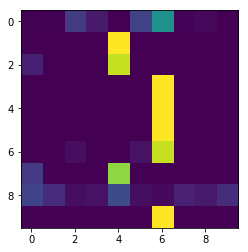

In [26]:
b = torch.randn((1,784))
Wb = torch.randn((1,10))
Qb = torch.matmul(Wb.transpose(0,1), b)

W = torch.randn((10,784))
scores = F.softmax(torch.matmul(Qb,W.transpose(0,1)),dim=1)
print(scores.shape)
torch.matmul(scores,W).shape

plt.imshow(scores)

### Contextual Feedback Network
$L^{i}(f^{i-1}_{t}, \beta^{i+1}_{t-1}; U^{i}, D^{i})$ &rarr; $f^{i}_{t}, \beta^{i}_{t}$

In [4]:
class CFB(nn.Module):
    def __init__(self, feature_size, hidden_size=100, dtype=torch.FloatTensor, num_layers=5,weight_transport=False):
        super(CFB, self).__init__()
        self.weight_transport = weight_transport
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        hidden_size = feature_size
        # forward weights: 1,2,3,4,5
        self.forward_params = nn.ParameterList([nn.Parameter(torch.randn(feature_size, hidden_size).type(dtype))] +\
                                               [nn.Parameter(torch.randn(hidden_size, hidden_size).type(dtype)) for _ in range(num_layers-1)])
        if weight_transport: # using same weights for forward and backward pass
            self.backward_params = self.forward_params
        else:
            # backward weights: 1,2,3,4,5
            self.backward_params = nn.ParameterList([nn.Parameter(torch.randn(feature_size, feature_size).type(dtype))] +\
                                        [nn.Parameter(torch.randn(hidden_size, hidden_size).type(dtype)) for _ in range(num_layers-1)])
        
        self.loss_store = None
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def reset(self):
        self.current_backward_context = []
        self.prior_backward_context = []
        self.prior_activities = []
        self.current_activities = []
        
    def init_loss(self,seq_len):
        if self.loss_store == None:
            self.loss_store = {i:[[] for _ in range(seq_len-1)] for i in range(self.num_layers)}
        
    def forward(self, feed_forward):
        seq_len = feed_forward.shape[0]
        self.reset()
        self.init_loss(seq_len)
        
        for seq_idx in range(seq_len):
            up = feed_forward[seq_idx].view(-1,784)
            
            for layer_idx in range(self.num_layers):
                U = self.forward_params[layer_idx] # up params
                D = self.backward_params[layer_idx] # down params
                
                if seq_idx != 0 and layer_idx + 1 != self.num_layers: # use backward context
                    if layer_idx == 0:
                        # fix loss saving
                        loss[seq_idx-1].append(F.mse_loss(up,self.prior_backward_context[layer_idx]).item())
                        
                    error = up - self.prior_backward_context[layer_idx] 
                    error.sum().backward(retain_graph=True)
                    #print(D.grad.shape)
                    #update = torch.mm(torch.t(up),error) * self.prior_backward_context[layer_idx]
                    #D.data.sub_(1e-3*update.data)
                    D.data.sub_(-1e-2*D.grad.data)
                    
                    down = compute(D, up, self.prior_backward_context[layer_idx+1])
                    up = compute(U, up, self.prior_backward_context[layer_idx+1])
                else: # no backward context
                    down = compute(D, up)
                    up = compute(U, up)
                
                self.current_backward_context.append(down)
                self.current_activities.append(up)                  
                
            self.prior_backward_context = self.current_backward_context
            self.prior_activities = self.current_activities
            self.current_activities = []
            self.current_backward_context = []
        return loss

In [5]:
model = CFB(FEATURE_SIZE)
import numpy as np
loss = None
for batch_idx, (data, target) in enumerate(train_loader):
    input_stimulus = data.view(-1,FEATURE_SIZE)
    break
for i in range(100):
    l = model(input_stimulus)
    if loss is None:
        loss = l
    else:
        loss = np.append(loss,l,axis=1)
    #print(i)
    #print (np.array(loss).shape)

In [27]:
np.array(loss).shape

(9, 100)

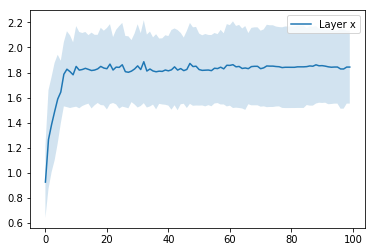

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
#for i in range(len(loss)):
m = np.mean(loss,axis=0)
s = np.std(loss,axis=0)
plt.plot(m,label='Layer x')
plt.fill_between(np.arange(len(m)),m + s, m - s,alpha=.2)
plt.legend()
plt.show()

In [7]:
x = nn.Parameter(torch.ones(2, 2, requires_grad=True))
y = torch.Tensor([[-1,2],[3,-4]])
y.requires_grad=True

cur = torch.Tensor([[5,4],[3,2]])
def f(a,b,cur):
    pred = F.relu(a * b)
    out = (pred - cur)**2
    return out.sum()
out = f(x,y,cur)
out.backward()
y.grad
torch.t(cur)

tensor([[ 5.,  3.],
        [ 4.,  2.]])

In [8]:
%%capture
'''from graphviz import Digraph
# make_dot was moved to https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot
d = make_dot(model(input_stimulus), params=dict(model.named_parameters()))
d.render(filename='one.png')'''

AttributeError: 'list' object has no attribute 'grad_fn'